In [1]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [4]:
import pysentiment2 as ps
lm = ps.LM()

In [5]:
stock_tweets = pd.read_csv("stock_tweets.csv")
prices_stock = pd.read_csv("stock_yfinance_data.csv")

In [6]:
stock_tweets["Date"] = pd.to_datetime(stock_tweets["Date"])
stock_tweets["Date"] = stock_tweets["Date"].dt.strftime("%Y-%m-%d")

stock_tweets

,Date,Tweet,Stock Name,Company Name
0,2022-09-29,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.


In [7]:
prices_stock["Date"] = pd.to_datetime(prices_stock["Date"])
prices_stock

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV


In [8]:
# Assuming your data is stored in a DataFrame named 'prices_stock'
prices_stock['Avg. Stock price'] = (prices_stock['High'] + prices_stock['Low']) / 2

# Drop all columns except 'Date', 'Stock Name', and 'Avg. Stock price'
prices_stock = prices_stock[['Date', 'Stock Name', 'Avg. Stock price']]

prices_stock

,Date,Stock Name,Avg. Stock price
0,2021-09-30,TSLA,260.688339
1,2021-10-01,TSLA,257.395004
2,2021-10-04,TSLA,263.848328
3,2021-10-05,TSLA,261.918335
4,2021-10-06,TSLA,259.979996
...,...,...,...
6295,2022-09-23,XPEV,13.376000
6296,2022-09-26,XPEV,14.450000
6297,2022-09-27,XPEV,14.190000
6298,2022-09-28,XPEV,13.055500


In [9]:
prices_stock = prices_stock.sort_values(by="Date")
prices_stock

,Date,Stock Name,Avg. Stock price
0,2021-09-30,TSLA,260.688339
252,2021-09-30,MSFT,284.724991
1008,2021-09-30,AMZN,165.045998
5292,2021-09-30,ENPH,149.864998
5796,2021-09-30,ZS,260.909988
...,...,...,...
503,2022-09-29,MSFT,237.180000
5795,2022-09-29,NIO,16.155000
251,2022-09-29,TSLA,274.714996
2015,2022-09-29,AAPL,143.699997


In [10]:
def get_scores(text):
    tokens = lm.tokenize(text)
    score = lm.get_score(tokens)
    return pd.Series([score['Positive'], score['Negative'], score['Polarity'], score['Subjectivity']])

# Apply the function to each tweet
stock_tweets[['Positive', 'Negative', 'Polarity', 'Subjectivity']] = stock_tweets['Tweet'].apply(get_scores)
stock_tweets

,Date,Tweet,Stock Name,Company Name,Positive,Negative,Polarity,Subjectivity
0,2022-09-29,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",0.0,2.0,-1.000000,0.074074
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",0.0,0.0,0.000000,0.000000
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",0.0,0.0,0.000000,0.000000
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",1.0,1.0,0.000000,0.100000
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",0.0,1.0,-0.999999,0.125000
...,...,...,...,...,...,...,...,...
80788,2021-10-07,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.,0.0,0.0,0.000000,0.000000
80789,2021-10-04,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.,0.0,0.0,0.000000,0.000000
80790,2021-10-01,Our record delivery results are a testimony of...,XPEV,XPeng Inc.,0.0,0.0,0.000000,0.000000
80791,2021-10-01,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.,0.0,0.0,0.000000,0.000000


In [11]:
sentiment_final = stock_tweets.groupby(["Date", "Stock Name"]).agg({
    "Positive": "sum",
    "Negative": "sum",
    "Polarity": "sum",
    "Subjectivity": "sum"
}).reset_index()

sentiment_final

,Date,Stock Name,Positive,Negative,Polarity,Subjectivity
0,2021-09-30,AAPL,0.0,2.0,-1.999998e+00,0.141667
1,2021-09-30,AMD,3.0,2.0,3.333332e-01,0.301879
2,2021-09-30,AMZN,3.0,3.0,-7.999990e-01,0.241667
3,2021-09-30,DIS,0.0,0.0,0.000000e+00,0.000000
4,2021-09-30,GOOG,0.0,0.0,0.000000e+00,0.000000
...,...,...,...,...,...,...
5905,2022-09-29,PG,4.0,9.0,-1.500000e+00,0.709600
5906,2022-09-29,PYPL,0.0,1.0,-9.999990e-01,0.047619
5907,2022-09-29,TSLA,31.0,57.0,-1.599999e+01,5.439018
5908,2022-09-29,TSM,1.0,2.0,-4.999992e-07,0.158385


In [12]:
sentiment_final = sentiment_final.drop(columns = ['Negative', 'Positive'])

In [13]:
aapl_prices = prices_stock[prices_stock['Stock Name'] == 'AAPL']
aapl_prices

,Date,Stock Name,Avg. Stock price
1764,2021-09-30,AAPL,142.830002
1765,2021-10-01,AAPL,141.014999
1766,2021-10-04,AAPL,140.240005
1767,2021-10-05,AAPL,140.800003
1768,2021-10-06,AAPL,140.259995
...,...,...,...
2011,2022-09-23,AAPL,150.014999
2012,2022-09-26,AAPL,151.705002
2013,2022-09-27,AAPL,152.334999
2014,2022-09-28,AAPL,147.739998


In [14]:
AAPL = sentiment_final[sentiment_final['Stock Name'] == 'AAPL']
AAPL.sort_values(by ='Date')

,Date,Stock Name,Polarity,Subjectivity
0,2021-09-30,AAPL,-1.999998,0.141667
13,2021-10-01,AAPL,0.000000,0.163271
28,2021-10-02,AAPL,0.999999,0.058824
42,2021-10-03,AAPL,-0.999999,0.032258
54,2021-10-04,AAPL,-3.999997,0.501325
...,...,...,...,...
5827,2022-09-25,AAPL,-0.999999,0.205269
5844,2022-09-26,AAPL,1.666665,0.558604
5862,2022-09-27,AAPL,-1.000000,0.184066
5874,2022-09-28,AAPL,-23.666650,3.986729


In [15]:
aapl_p = AAPL.merge(aapl_prices, on=["Date", "Stock Name"], how="inner")
aapl_p.sort_values(by='Date')

ValueError: You are trying to merge on object and datetime64[ns] columns. If you wish to proceed you should use pd.concat

In [ ]:
aapl_p = aapl_p.sort_values(by="Date")

# Setting up the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting Avg. Stock price on the left y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Avg. Stock price', color='tab:blue')
ax1.plot(aapl_p['Date'], aapl_p['Avg. Stock price'], color='tab:blue', label='Avg. Stock price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Creating a second y-axis for the Polarity
ax2 = ax1.twinx()
ax2.set_ylabel('Polarity', color='tab:red')
ax2.plot(aapl_p['Date'], aapl_p['Polarity'], color='tab:red', label='Polarity')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Creating a third y-axis for the Subjectivity (using twinx and then offsetting it)
ax3 = ax1.twinx()
# Offset the third y-axis to the right
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Subjectivity', color='tab:green')
ax3.plot(aapl_p['Date'], aapl_p['Subjectivity'], color='tab:green', label='Subjectivity')
ax3.tick_params(axis='y', labelcolor='tab:green')

ax1.tick_params(axis='x', rotation=45)

# Display fewer date labels (e.g., show every 10th label)

ticks_to_show = ax1.get_xticks()[::50]  # adjust the number as needed
ax1.set_xticks(ticks_to_show)

# Use a date formatter

# Calculating and displaying the correlation coefficients
corr_polarity = aapl_p['Avg. Stock price'].corr(aapl_p['Polarity'])
corr_subjectivity = aapl_p['Avg. Stock price'].corr(aapl_p['Subjectivity'])
plt.title(f'Avg. Stock price vs Polarity vs Subjectivity\n(Correlation with Price - Polarity: {corr_polarity:.4f}, Subjectivity: {corr_subjectivity:.4f})')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
tsla_prices = prices_stock[prices_stock['Stock Name'] == 'TSLA']
tsla_prices

In [ ]:
TSLA = sentiment_final[sentiment_final['Stock Name'] == 'TSLA']
tsla_p = TSLA.merge(tsla_prices, on=["Date", "Stock Name"], how="inner")
tsla_p.sort_values(by='Date')


In [ ]:
tsla_p = tsla_p.sort_values(by="Date")

# Setting up the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting Avg. Stock price on the left y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Avg. Stock price', color='tab:blue')
ax1.plot(tsla_p['Date'], tsla_p['Avg. Stock price'], color='tab:blue', label='Avg. Stock price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Creating a second y-axis for the Polarity
ax2 = ax1.twinx()
ax2.set_ylabel('Polarity', color='tab:red')
ax2.plot(tsla_p['Date'], tsla_p['Polarity'], color='tab:red', label='Polarity')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Creating a third y-axis for the Subjectivity (using twinx and then offsetting it)
ax3 = ax1.twinx()
# Offset the third y-axis to the right
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Subjectivity', color='tab:green')
ax3.plot(tsla_p['Date'], tsla_p['Subjectivity'], color='tab:green', label='Subjectivity')
ax3.tick_params(axis='y', labelcolor='tab:green')

ax1.tick_params(axis='x', rotation=45)

# Display fewer date labels (e.g., show every 10th label)

ticks_to_show = ax1.get_xticks()[::50]  # adjust the number as needed
ax1.set_xticks(ticks_to_show)

# Use a date formatter

# Calculating and displaying the correlation coefficients
corr_polarity = tsla_p['Avg. Stock price'].corr(tsla_p['Polarity'])
corr_subjectivity = tsla_p['Avg. Stock price'].corr(tsla_p['Subjectivity'])
plt.title(f'Avg. Stock price vs Polarity vs Subjectivity\n(Correlation with Price - Polarity: {corr_polarity:.4f}, Subjectivity: {corr_subjectivity:.4f})')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
tsm_prices = prices_stock[prices_stock['Stock Name'] == 'TSM']
tsm_prices

In [ ]:
TSM = sentiment_final[sentiment_final['Stock Name'] == 'TSM']
tsm_p = TSM.merge(tsm_prices, on = ['Date', 'Stock Name'], how= 'inner')
tsm_p

In [ ]:
tsm_p = tsm_p.sort_values(by="Date")

# Setting up the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting Avg. Stock price on the left y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Avg. Stock price', color='tab:blue')
ax1.plot(tsm_p['Date'], tsm_p['Avg. Stock price'], color='tab:blue', label='Avg. Stock price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Creating a second y-axis for the Polarity
ax2 = ax1.twinx()
ax2.set_ylabel('Polarity', color='tab:red')
ax2.plot(tsm_p['Date'], tsm_p['Polarity'], color='tab:red', label='Polarity')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Creating a third y-axis for the Subjectivity (using twinx and then offsetting it)
ax3 = ax1.twinx()
# Offset the third y-axis to the right
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Subjectivity', color='tab:green')
ax3.plot(tsm_p['Date'], tsm_p['Subjectivity'], color='tab:green', label='Subjectivity')
ax3.tick_params(axis='y', labelcolor='tab:green')

ax1.tick_params(axis='x', rotation=45)

# Display fewer date labels (e.g., show every 10th label)

ticks_to_show = ax1.get_xticks()[::50]  # adjust the number as needed
ax1.set_xticks(ticks_to_show)

# Use a date formatter

# Calculating and displaying the correlation coefficients
corr_polarity = tsm_p['Avg. Stock price'].corr(tsm_p['Polarity'])
corr_subjectivity = tsm_p['Avg. Stock price'].corr(tsm_p['Subjectivity'])
plt.title(f'Avg. Stock price vs Polarity vs Subjectivity\n(Correlation with Price - Polarity: {corr_polarity:.4f}, Subjectivity: {corr_subjectivity:.4f})')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
########################################
################################################
##################################################################
from sklearn.model_selection import RandomizedSearchCV

X = tsla_p[['Subjectivity', 'Polarity']]
y = tsla_p['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Define the hyperparameters and their distributions
param_dist = {
    'n_estimators': np.arange(10, 200, 10),
    'max_features': [ 'sqrt', 'log2'],
    'max_depth': np.arange(1, 20, 1),
    'min_samples_split': np.arange(2, 20, 1),
    'min_samples_leaf': np.arange(1, 20, 1),
    'bootstrap': [True, False]
}

# Initialize the regressor
rf = RandomForestRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

# Print the best parameters
print(random_search.best_params_)


In [ ]:
######################################################
############################################################
#################################################################
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


#machine learning - TSLA - rf regression
X = tsla_p[['Subjectivity', 'Polarity']]
y = tsla_p['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest regressor instance
clf_rf = RandomForestRegressor(n_estimators = 20,
min_samples_split = 14,
min_samples_leaf = 17,
max_features = 'sqrt',
max_depth = 19,
bootstrap = True
)

# Fit the model to the training data
clf_rf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_rf.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")



In [ ]:
tsla_p = tsla_p.sort_values(by="Date")

#machine learning - TSLA - rf regression
X = tsla_p[['Subjectivity', 'Polarity']]
y = tsla_p['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest regressor instance
clf_rf = RandomForestRegressor(n_estimators = 20,
min_samples_split = 14,
min_samples_leaf = 17,
max_features = 'sqrt',
max_depth = 19,
bootstrap = True
)

# Fit the model to the training data
clf_rf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_rf.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


plot_df = pd.DataFrame({
    'Date': tsla_p.loc[y_test.index, 'Date'],
    'Actual': y_test,
    'Predicted': y_pred
})

# Sort the DataFrame by date
plot_df = plot_df.sort_values(by="Date")

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))


# Plotting actual and predicted stock prices against Date
ax.plot(plot_df['Date'], plot_df['Actual'], color='tab:blue', label='Actual Stock Price')
ax.plot(plot_df['Date'], plot_df['Predicted'], color='tab:red', linestyle='--', label='Predicted Stock Price')

correlation = plot_df['Actual'].corr(plot_df['Predicted'])
print(f"Correlation between Actual and Predicted Stock Prices: {correlation:.4f}")

# Setting labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.set_title(f'Actual vs Predicted Stock Prices - Random Forest Regression - TSLA (Correlation: {correlation:.4f})')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()





In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

##############################################
####################################################
#######################################################


# - regression - tsla

X = tsla_p[['Subjectivity', 'Polarity']]  
y = tsla_p['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Linear Regression model instance
clf_lr = LinearRegression()

# Fit the model to the training data
clf_lr.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_lr.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


In [ ]:
tsla_p = tsla_p.sort_values(by="Date")


X = tsla_p[['Subjectivity', 'Polarity']]  
y = tsla_p['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Linear Regression model instance
clf_lr = LinearRegression()

# Fit the model to the training data
clf_lr.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_lr.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


plot_df = pd.DataFrame({
    'Date': tsla_p.loc[y_test.index, 'Date'],
    'Actual': y_test,
    'Predicted': y_pred
})

# Sort the DataFrame by date
plot_df = plot_df.sort_values(by="Date")

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting actual and predicted stock prices against Date
ax.plot(plot_df['Date'], plot_df['Actual'], color='tab:blue', label='Actual Stock Price')
ax.plot(plot_df['Date'], plot_df['Predicted'], color='tab:red', linestyle='--', label='Predicted Stock Price')

correlation = plot_df['Actual'].corr(plot_df['Predicted'])
print(f"Correlation between Actual and Predicted Stock Prices: {correlation:.4f}")

# Setting labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.set_title(f'Actual vs Predicted Stock Prices - Linear Regression - TSLA (Correlation: {correlation:.4f})')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
###########################################
##########################################################
###############################################################



X = aapl_p[['Subjectivity', 'Polarity']]
y = aapl_p['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Define the hyperparameters and their distributions
param_dist = {
    'n_estimators': np.arange(10, 200, 10),
    'max_features': [ 'sqrt', 'log2'],
    'max_depth': np.arange(1, 20, 1),
    'min_samples_split': np.arange(2, 20, 1),
    'min_samples_leaf': np.arange(1, 20, 1),
    'bootstrap': [True, False]
}

# Initialize the regressor
rf = RandomForestRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

# Print the best parameters
print(random_search.best_params_)

In [ ]:


#machine learning - AAPL - rf regression
X = aapl_p[['Subjectivity', 'Polarity']]
y = aapl_p['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest regressor instance
clf_rf = RandomForestRegressor(n_estimators = 150,
min_samples_split = 8,
min_samples_leaf = 12,
max_features = 'sqrt',
max_depth = 1,
bootstrap = True
)

# Fit the model to the training data
clf_rf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_rf.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

In [ ]:
aapl_p = aapl_p.sort_values(by="Date")



#machine learning - AAPL - rf regression
X = aapl_p[['Subjectivity', 'Polarity']]
y = aapl_p['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest regressor instance
clf_rf = RandomForestRegressor(n_estimators = 150,
min_samples_split = 8,
min_samples_leaf = 12,
max_features = 'sqrt',
max_depth = 1,
bootstrap = True
)

# Fit the model to the training data
clf_rf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_rf.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)




plot_df = pd.DataFrame({
    'Date': aapl_p.loc[y_test.index, 'Date'],
    'Actual': y_test,
    'Predicted': y_pred
})

# Sort the DataFrame by date
plot_df = plot_df.sort_values(by="Date")

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting actual and predicted stock prices against Date
ax.plot(plot_df['Date'], plot_df['Actual'], color='tab:blue', label='Actual Stock Price')
ax.plot(plot_df['Date'], plot_df['Predicted'], color='tab:red', linestyle='--', label='Predicted Stock Price')

# Setting labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.set_title(f'Actual vs Predicted Stock Prices - Random Forest Regression - AAPL (Correlation: {correlation:.4f})')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

correlation = plot_df['Actual'].corr(plot_df['Predicted'])
print(f"Correlation between Actual and Predicted Stock Prices: {correlation:.2f}")



In [ ]:
X = aapl_p[['Subjectivity', 'Polarity']]  
y = aapl_p['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Linear Regression model instance
clf_lr = LinearRegression()

# Fit the model to the training data
clf_lr.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_lr.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Correlation between Actual and Predicted Stock Prices: -0.07


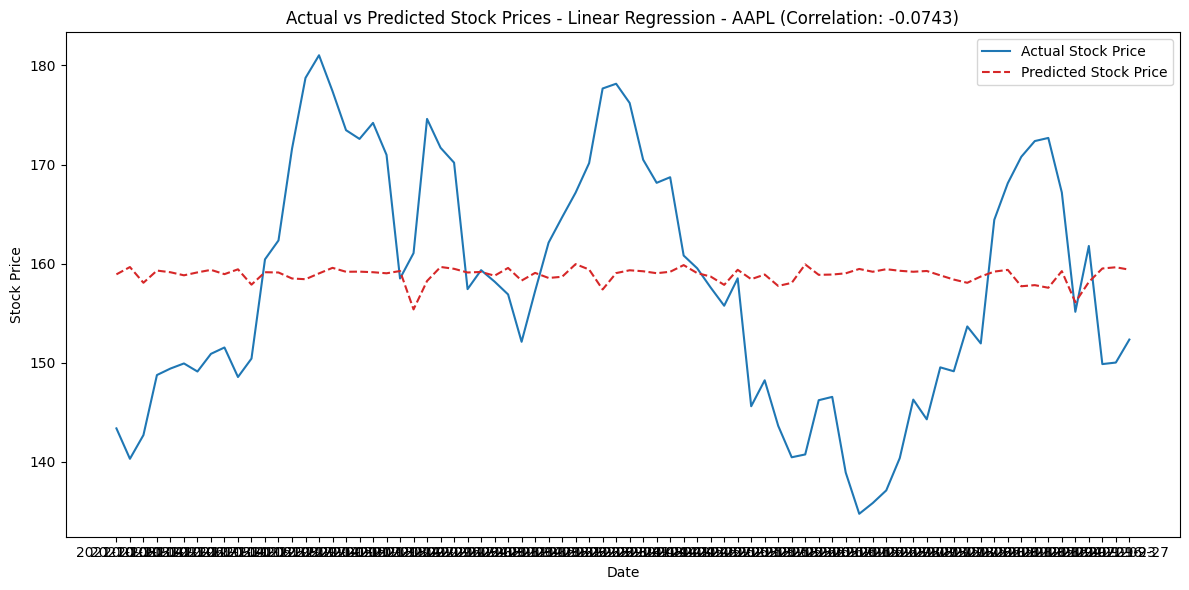

In [110]:
aapl_p = aapl_p.sort_values(by="Date")


X = aapl_p[['Subjectivity', 'Polarity']]  
y = aapl_p['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Linear Regression model instance
clf_lr = LinearRegression()

# Fit the model to the training data
clf_lr.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_lr.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plot_df = pd.DataFrame({
    'Date': aapl_p.loc[y_test.index, 'Date'],
    'Actual': y_test,
    'Predicted': y_pred
})

# Sort the DataFrame by date
plot_df = plot_df.sort_values(by="Date")

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

correlation = plot_df['Actual'].corr(plot_df['Predicted'])
print(f"Correlation between Actual and Predicted Stock Prices: {correlation:.2f}")

# Plotting actual and predicted stock prices against Date
ax.plot(plot_df['Date'], plot_df['Actual'], color='tab:blue', label='Actual Stock Price')
ax.plot(plot_df['Date'], plot_df['Predicted'], color='tab:red', linestyle='--', label='Predicted Stock Price')

# Setting labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.set_title(f'Actual vs Predicted Stock Prices - Linear Regression - AAPL (Correlation: {correlation:.4f})')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()




In [111]:
###########################################
##########################################################
###############################################################
# TSM


X = tsm_p[['Subjectivity', 'Polarity']]
y = tsm_p['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Define the hyperparameters and their distributions
param_dist = {
    'n_estimators': np.arange(10, 200, 10),
    'max_features': [ 'sqrt', 'log2'],
    'max_depth': np.arange(1, 20, 1),
    'min_samples_split': np.arange(2, 20, 1),
    'min_samples_leaf': np.arange(1, 20, 1),
    'bootstrap': [True, False]
}

# Initialize the regressor
rf = RandomForestRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

# Print the best parameters
print(random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 110, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'max_depth': 2, 'bootstrap': False}


In [127]:
#machine learning - TSM - rf regression
X = tsm_p[['Subjectivity', 'Polarity']]
y = tsm_p['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest regressor instance
clf_rf = RandomForestRegressor(n_estimators = 110,
min_samples_split = 15,
min_samples_leaf = 9,
max_features = 'sqrt',
max_depth = 2,
bootstrap = False
)

# Fit the model to the training data
clf_rf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_rf.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 13.26080753153334
Mean Squared Error: 250.60201492271958
R-squared: 0.024507730898865154


Correlation between Actual and Predicted Stock Prices: 0.16


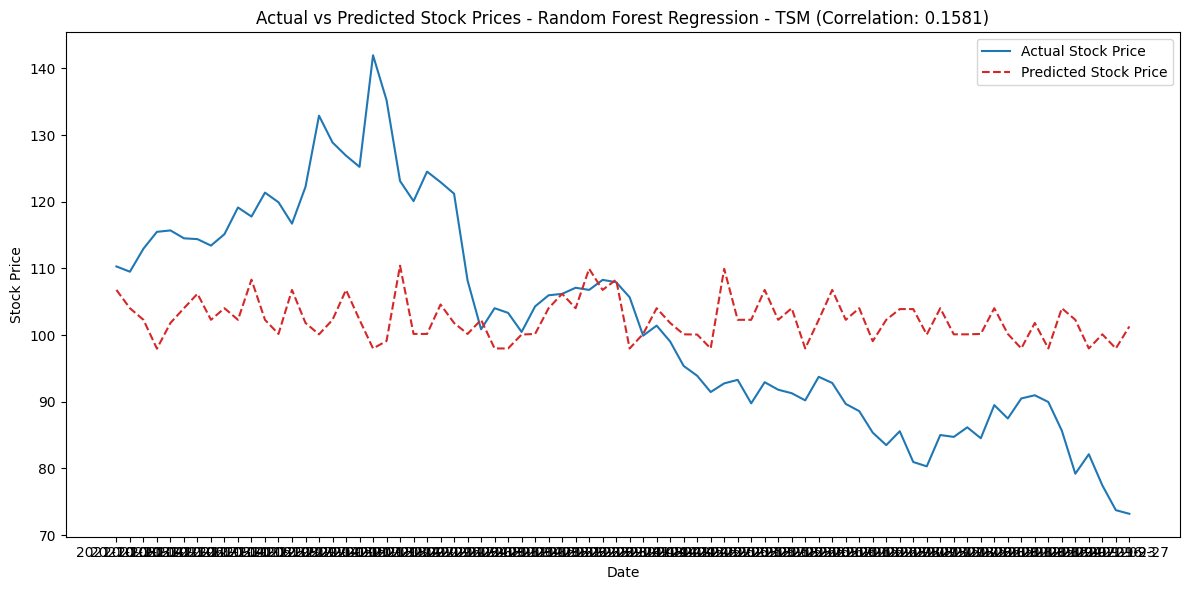

In [131]:
tsm_p = tsm_p.sort_values(by="Date")



#machine learning - TSM - rf regression
X = tsm_p[['Subjectivity', 'Polarity']]
y = tsm_p['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest regressor instance
clf_rf = RandomForestRegressor(n_estimators = 110,
min_samples_split = 15,
min_samples_leaf = 9,
max_features = 'sqrt',
max_depth = 2,
bootstrap = False
)

# Fit the model to the training data
clf_rf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_rf.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)





plot_df = pd.DataFrame({
    'Date': tsm_p.loc[y_test.index, 'Date'],
    'Actual': y_test,
    'Predicted': y_pred
})

# Sort the DataFrame by date
plot_df = plot_df.sort_values(by="Date")

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting actual and predicted stock prices against Date
ax.plot(plot_df['Date'], plot_df['Actual'], color='tab:blue', label='Actual Stock Price')
ax.plot(plot_df['Date'], plot_df['Predicted'], color='tab:red', linestyle='--', label='Predicted Stock Price')

correlation = plot_df['Actual'].corr(plot_df['Predicted'])
print(f"Correlation between Actual and Predicted Stock Prices: {correlation:.2f}")

# Setting labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.set_title(f'Actual vs Predicted Stock Prices - Random Forest Regression - TSM (Correlation: {correlation:.4f})')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()



In [133]:
X = tsm_p[['Subjectivity', 'Polarity']]  
y = tsm_p['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Linear Regression model instance
clf_lr = LinearRegression()

# Fit the model to the training data
clf_lr.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_lr.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")



Mean Absolute Error: 13.469755034400626
Mean Squared Error: 254.12279116980014
R-squared: 0.010802773213983374


Correlation between Actual and Predicted Stock Prices: 0.12


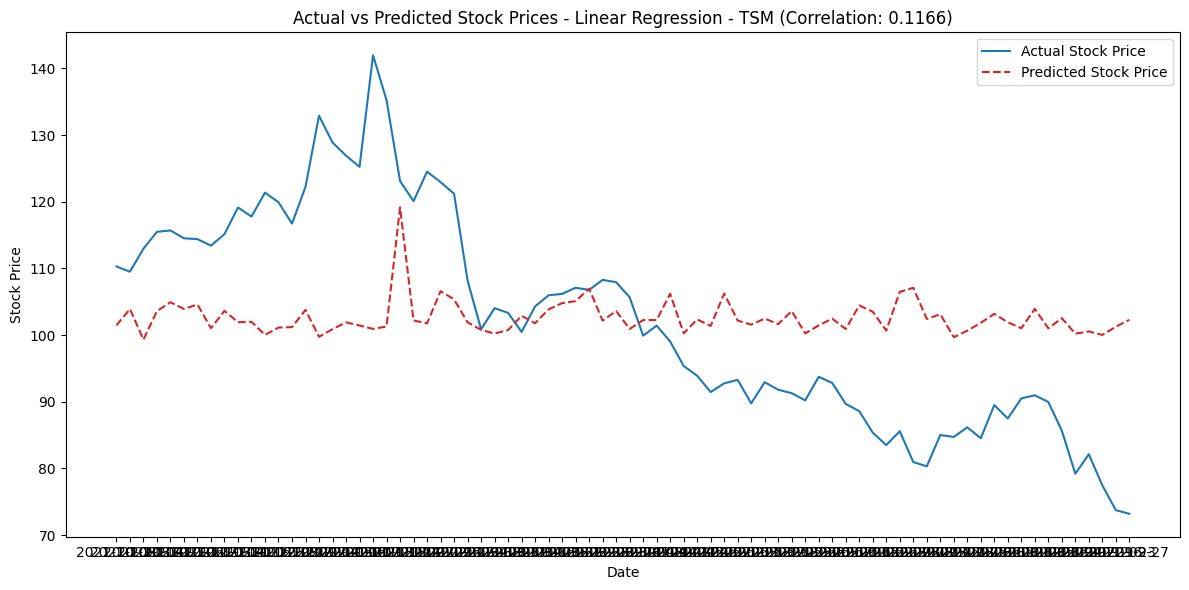

In [135]:
tsm_p = tsm_p.sort_values(by="Date")

X = tsm_p[['Subjectivity', 'Polarity']]  
y = tsm_p['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Linear Regression model instance
clf_lr = LinearRegression()

# Fit the model to the training data
clf_lr.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_lr.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plot_df = pd.DataFrame({
    'Date': tsm_p.loc[y_test.index, 'Date'],
    'Actual': y_test,
    'Predicted': y_pred
})

# Sort the DataFrame by date
plot_df = plot_df.sort_values(by="Date")

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting actual and predicted stock prices against Date
ax.plot(plot_df['Date'], plot_df['Actual'], color='tab:blue', label='Actual Stock Price')
ax.plot(plot_df['Date'], plot_df['Predicted'], color='tab:red', linestyle='--', label='Predicted Stock Price')

correlation = plot_df['Actual'].corr(plot_df['Predicted'])
print(f"Correlation between Actual and Predicted Stock Prices: {correlation:.2f}")
# Setting labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.set_title(f'Actual vs Predicted Stock Prices - Linear Regression - TSM (Correlation: {correlation:.4f})')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()




In [21]:

# Shift the date in sentiment_final by one day forward
sentiment_final_shifted = sentiment_final.copy()
# Convert the 'Date' column in both DataFrames to datetime format

sentiment_final_shifted['Date'] = pd.to_datetime(sentiment_final_shifted['Date'])
prices_stock['Date'] = pd.to_datetime(prices_stock['Date'])
sentiment_final_shifted['Date'] = sentiment_final_shifted['Date'] + pd.Timedelta(days=1)

# Now, you can merge
merged_data_notnormaltime = pd.merge(sentiment_final_shifted, prices_stock, on=['Date', 'Stock Name'], how='left')


# Merge the shifted sentiment_final with prices_stock
merged_data_notnormaltime = pd.merge(sentiment_final_shifted, prices_stock, on=['Date', 'Stock Name'], how='left')

# Rename the stock columns to indicate they are the next day's values
rename_columns = {
    'Open': 'Next_Day_Open',
    'Close': 'Next_Day_Close',
    'High': 'Next_Day_High',
    'Low': 'Next_Day_Low',
    'Adj Close': 'Next_Day_Adj_Close',
    'Volume': 'Next_Day_Volume'
}
merged_data_notnormaltime = merged_data_notnormaltime.rename(columns=rename_columns)


merged_data_notnormaltime=merged_data_notnormaltime.dropna()
merged_data_notnormaltime

,Date,Stock Name,Polarity,Subjectivity,Avg. Stock price
0,2021-10-01,AAPL,-1.999998,0.141667,141.014999
1,2021-10-01,AMD,0.333333,0.301879,101.820000
2,2021-10-01,AMZN,-0.799999,0.241667,164.127747
3,2021-10-01,DIS,0.000000,0.000000,174.645004
4,2021-10-01,GOOG,0.000000,0.000000,135.224251
...,...,...,...,...,...
5888,2022-09-29,PYPL,-0.999999,0.047619,89.134998
5889,2022-09-29,TSLA,1.666667,3.831607,274.714996
5890,2022-09-29,TSM,0.999999,0.508076,69.580002
5891,2022-09-29,VZ,0.000000,0.000000,38.825001


In [22]:
merged_data_notnormaltime['Date'] = pd.to_datetime(merged_data_notnormaltime['Date'])

# Sort by 'Date'
merged_data_notnormaltime = merged_data_notnormaltime.sort_values(by='Date', ascending=True)
merged_data_notnormaltime

,Date,Stock Name,Polarity,Subjectivity,Avg. Stock price
0,2021-10-01,AAPL,-1.999998,0.141667,141.014999
12,2021-10-01,XPEV,0.000000,0.000000,35.920000
11,2021-10-01,TSM,5.999996,1.644497,111.300003
10,2021-10-01,TSLA,-5.533331,3.950806,257.395004
8,2021-10-01,NIO,1.000000,0.334127,35.964998
...,...,...,...,...,...
5875,2022-09-29,AMD,-1.000000,0.100000,65.014999
5874,2022-09-29,AAPL,-23.666650,3.986729,143.699997
5891,2022-09-29,VZ,0.000000,0.000000,38.825001
5882,2022-09-29,INTC,0.000000,0.000000,26.485001


In [23]:
tsla_shifted = merged_data_notnormaltime[merged_data_notnormaltime['Stock Name'] == 'TSLA']
tsla_shifted

,Date,Stock Name,Polarity,Subjectivity,Avg. Stock price
10,2021-10-01,TSLA,-5.533331,3.950806,257.395004
52,2021-10-04,TSLA,-4.466661,2.878749,263.848328
66,2021-10-05,TSLA,-12.933328,6.635733,261.918335
83,2021-10-06,TSLA,-13.266657,3.989051,259.979996
98,2021-10-07,TSLA,-1.499998,3.288664,264.730011
...,...,...,...,...,...
5794,2022-09-23,TSLA,-15.333322,4.821624,278.660004
5841,2022-09-26,TSLA,-9.666661,2.325625,277.199997
5858,2022-09-27,TSLA,-4.023807,3.696460,283.090012
5871,2022-09-28,TSLA,-8.999997,4.481737,283.285004


In [24]:
corr_polarity = tsla_shifted['Avg. Stock price'].corr(tsla_shifted['Polarity'])
corr_subjectivity = tsla_shifted['Avg. Stock price'].corr(tsla_shifted['Subjectivity'])

print(f"Next day Correlation for TSLA: {corr_polarity:.4f}")
print(f"Next day Correlation for TSLA: {corr_subjectivity:.4f}")

Next day Correlation for TSLA: 0.1388
Next day Correlation for TSLA: 0.1538


In [26]:
aapl_shifted = merged_data_notnormaltime[merged_data_notnormaltime['Stock Name'] == 'AAPL']
aapl_shifted

,Date,Stock Name,Polarity,Subjectivity,Avg. Stock price
0,2021-10-01,AAPL,-1.999998,0.141667,141.014999
42,2021-10-04,AAPL,-0.999999,0.032258,140.240005
54,2021-10-05,AAPL,-3.999997,0.501325,140.800003
70,2021-10-06,AAPL,0.000000,0.000000,140.259995
85,2021-10-07,AAPL,1.000000,0.074074,143.470001
...,...,...,...,...,...
5778,2022-09-23,AAPL,0.000000,0.076190,150.014999
5827,2022-09-26,AAPL,-0.999999,0.205269,151.705002
5844,2022-09-27,AAPL,1.666665,0.558604,152.334999
5862,2022-09-28,AAPL,-1.000000,0.184066,147.739998


In [27]:
corr_polarity = aapl_shifted['Avg. Stock price'].corr(aapl_shifted['Polarity'])
corr_subjectivity = aapl_shifted['Avg. Stock price'].corr(aapl_shifted['Subjectivity'])

print(f"Next day Correlation for AAPL: {corr_polarity:.4f}")
print(f"Next day Correlation for AAPL: {corr_subjectivity:.4f}")

Next day Correlation for AAPL: 0.0127
Next day Correlation for AAPL: -0.0030


In [28]:
tsm_shifted = merged_data_notnormaltime[merged_data_notnormaltime['Stock Name'] == 'TSM']
tsm_shifted

,Date,Stock Name,Polarity,Subjectivity,Avg. Stock price
11,2021-10-01,TSM,5.999996,1.644497,111.300003
53,2021-10-04,TSM,-0.999999,0.955357,109.974998
67,2021-10-05,TSM,-1.000000,1.935317,109.785000
84,2021-10-06,TSM,1.599999,0.969877,108.549999
99,2021-10-07,TSM,7.999993,2.109998,111.099998
...,...,...,...,...,...
5795,2022-09-23,TSM,0.499999,1.405646,73.739998
5842,2022-09-26,TSM,0.999999,0.309524,73.555000
5859,2022-09-27,TSM,0.333333,0.486854,73.195000
5872,2022-09-28,TSM,1.600000,0.884699,71.494999


In [29]:
corr_polarity = tsm_shifted['Avg. Stock price'].corr(tsm_shifted['Polarity'])
corr_subjectivity = tsm_shifted['Avg. Stock price'].corr(tsm_shifted['Subjectivity'])

print(f"Next day Correlation for TSM: {corr_polarity:.4f}")
print(f"Next day Correlation for TSM: {corr_subjectivity:.4f}")

Next day Correlation for TSM: 0.0054
Next day Correlation for TSM: 0.1474


In [30]:
########################################
################################################
##################################################################
from sklearn.model_selection import RandomizedSearchCV

X = tsla_shifted[['Subjectivity', 'Polarity']]
y = tsla_shifted['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Define the hyperparameters and their distributions
param_dist = {
    'n_estimators': np.arange(10, 200, 10),
    'max_features': [ 'sqrt', 'log2'],
    'max_depth': np.arange(1, 20, 1),
    'min_samples_split': np.arange(2, 20, 1),
    'min_samples_leaf': np.arange(1, 20, 1),
    'bootstrap': [True, False]
}

# Initialize the regressor
rf = RandomForestRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

# Print the best parameters
print(random_search.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 90, 'min_samples_split': 6, 'min_samples_leaf': 19, 'max_features': 'sqrt', 'max_depth': 17, 'bootstrap': True}


In [50]:
#########################################
#######################################################
################################################################


# next days stock price - machine learning - TSLA

######################################################
############################################################
#################################################################


#machine learning - TSLA - rf regression
X = tsla_shifted[['Subjectivity', 'Polarity']]
y = tsla_shifted['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest regressor instance
clf_rf = RandomForestRegressor(n_estimators = 90,
min_samples_split = 6,
min_samples_leaf = 19,
max_features = 'sqrt',
max_depth = 17,
bootstrap = True
)

# Fit the model to the training data
clf_rf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_rf.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")




Mean Absolute Error: 35.41401138084319
Mean Squared Error: 1846.7773600993846
R-squared: 0.06730422617530818


Correlation between Actual and Predicted Stock Prices: 0.2817


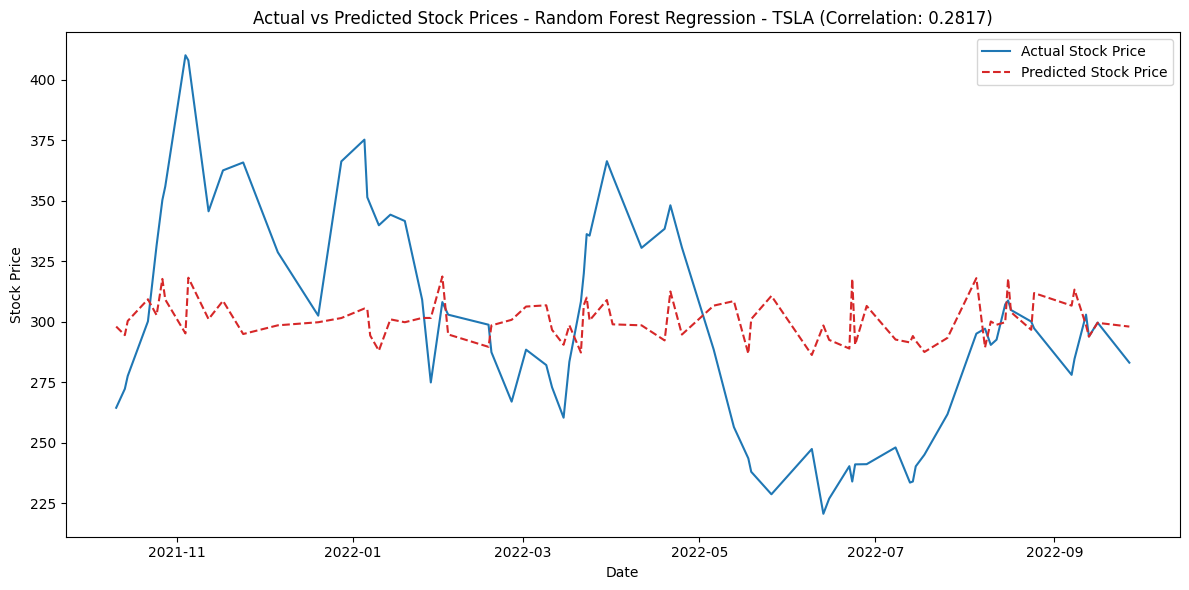

In [90]:
tsla_shifted = tsla_shifted.sort_values(by="Date")

X = tsla_shifted[['Subjectivity', 'Polarity']]
y = tsla_shifted['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest regressor instance
clf_rf = RandomForestRegressor(n_estimators = 90,
min_samples_split = 6,
min_samples_leaf = 19,
max_features = 'sqrt',
max_depth = 17,
bootstrap = True
)

# Fit the model to the training data
clf_rf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_rf.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Fit the model to the training data
clf_rf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_rf.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)



plot_df = pd.DataFrame({
    'Date': tsla_shifted.loc[y_test.index, 'Date'],
    'Actual': y_test,
    'Predicted': y_pred
})

# Sort the DataFrame by date
plot_df = plot_df.sort_values(by="Date")

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting actual and predicted stock prices against Date
ax.plot(plot_df['Date'], plot_df['Actual'], color='tab:blue', label='Actual Stock Price')
ax.plot(plot_df['Date'], plot_df['Predicted'], color='tab:red', linestyle='--', label='Predicted Stock Price')

correlation = plot_df['Actual'].corr(plot_df['Predicted'])
print(f"Correlation between Actual and Predicted Stock Prices: {correlation:.4f}")

# Setting labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.set_title(f'Actual vs Predicted Stock Prices - Random Forest Regression - TSLA (Correlation: {correlation:.4f})')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()





In [33]:

##############################################
####################################################
#######################################################


# - regression - tsla

X = tsla_shifted[['Subjectivity', 'Polarity']]  
y = tsla_shifted['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Linear Regression model instance
clf_lr = LinearRegression()

# Fit the model to the training data
clf_lr.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_lr.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Absolute Error: 34.77665693177284
Mean Squared Error: 1858.178909103087
R-squared: 0.06154599196659116


Correlation between Actual and Predicted Stock Prices: 0.2483


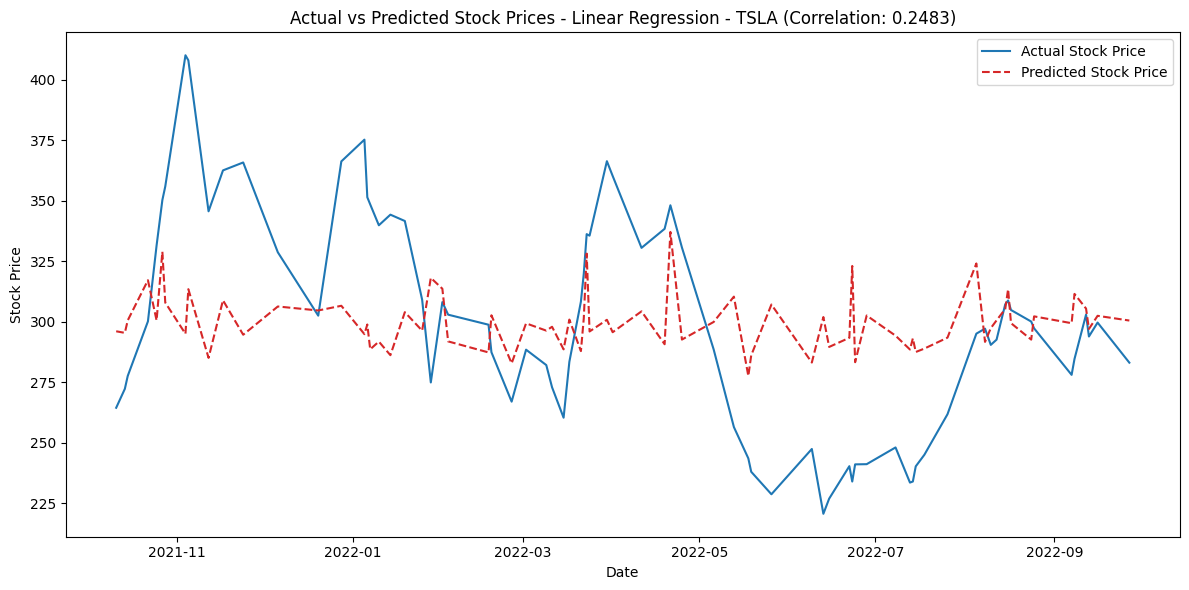

In [87]:
tsla_shifted = tsla_shifted.sort_values(by="Date")

# - regression - tsla

X = tsla_shifted[['Subjectivity', 'Polarity']]  
y = tsla_shifted['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Linear Regression model instance
clf_lr = LinearRegression()

# Fit the model to the training data
clf_lr.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_lr.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plot_df = pd.DataFrame({
    'Date': tsla_shifted.loc[y_test.index, 'Date'],
    'Actual': y_test,
    'Predicted': y_pred
})

# Sort the DataFrame by date
plot_df = plot_df.sort_values(by="Date")

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting actual and predicted stock prices against Date
ax.plot(plot_df['Date'], plot_df['Actual'], color='tab:blue', label='Actual Stock Price')
ax.plot(plot_df['Date'], plot_df['Predicted'], color='tab:red', linestyle='--', label='Predicted Stock Price')

correlation = plot_df['Actual'].corr(plot_df['Predicted'])
print(f"Correlation between Actual and Predicted Stock Prices: {correlation:.4f}")

# Setting labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.set_title(f'Actual vs Predicted Stock Prices - Linear Regression - TSLA (Correlation: {correlation:.4f})')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [35]:
###########################################
##########################################################
###############################################################

# aapl 

X = aapl_shifted[['Subjectivity', 'Polarity']]
y = aapl_shifted['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Define the hyperparameters and their distributions
param_dist = {
    'n_estimators': np.arange(10, 200, 10),
    'max_features': [ 'sqrt', 'log2'],
    'max_depth': np.arange(1, 20, 1),
    'min_samples_split': np.arange(2, 20, 1),
    'min_samples_leaf': np.arange(1, 20, 1),
    'bootstrap': [True, False]
}

# Initialize the regressor
rf = RandomForestRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

# Print the best parameters
print(random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 150, 'min_samples_split': 8, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'max_depth': 1, 'bootstrap': True}


In [81]:


#machine learning - AAPL - rf regression
X = aapl_shifted[['Subjectivity', 'Polarity']]
y = aapl_shifted['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest regressor instance
clf_rf = RandomForestRegressor(n_estimators = 150,
min_samples_split = 8,
min_samples_leaf = 12,
max_features = 'sqrt',
max_depth = 1,
bootstrap = True
)

# Fit the model to the training data
clf_rf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_rf.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 10.77376444573214
Mean Squared Error: 149.13473998078524
R-squared: 0.0014058801237892826


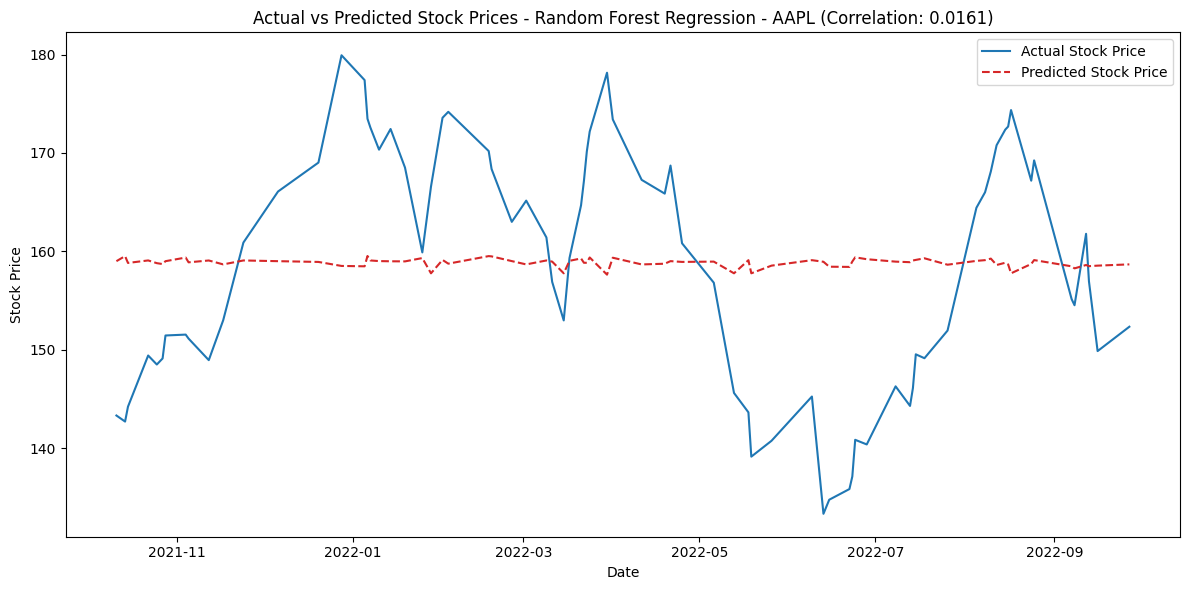

Correlation between Actual and Predicted Stock Prices: 0.03


In [84]:
aapl_shifted = aapl_shifted.sort_values(by="Date")



#machine learning - AAPL - rf regression
X = aapl_shifted[['Subjectivity', 'Polarity']]
y = aapl_shifted['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest regressor instance
clf_rf = RandomForestRegressor(n_estimators = 150,
min_samples_split = 8,
min_samples_leaf = 12,
max_features = 'sqrt',
max_depth = 1,
bootstrap = True
)

# Fit the model to the training data
clf_rf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_rf.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plot_df = pd.DataFrame({
    'Date': aapl_shifted.loc[y_test.index, 'Date'],
    'Actual': y_test,
    'Predicted': y_pred
})

# Sort the DataFrame by date
plot_df = plot_df.sort_values(by="Date")

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting actual and predicted stock prices against Date
ax.plot(plot_df['Date'], plot_df['Actual'], color='tab:blue', label='Actual Stock Price')
ax.plot(plot_df['Date'], plot_df['Predicted'], color='tab:red', linestyle='--', label='Predicted Stock Price')

# Setting labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.set_title(f'Actual vs Predicted Stock Prices - Random Forest Regression - AAPL (Correlation: {correlation:.4f})')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

correlation = plot_df['Actual'].corr(plot_df['Predicted'])
print(f"Correlation between Actual and Predicted Stock Prices: {correlation:.2f}")



In [91]:

##############################################
####################################################
#######################################################


# - regression - aapl

X = aapl_shifted[['Subjectivity', 'Polarity']]  
y = aapl_shifted['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Linear Regression model instance
clf_lr = LinearRegression()

# Fit the model to the training data
clf_lr.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_lr.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Absolute Error: 10.796848758276933
Mean Squared Error: 150.60151060401103
R-squared: -0.008415496972849157


Correlation between Actual and Predicted Stock Prices: -0.06


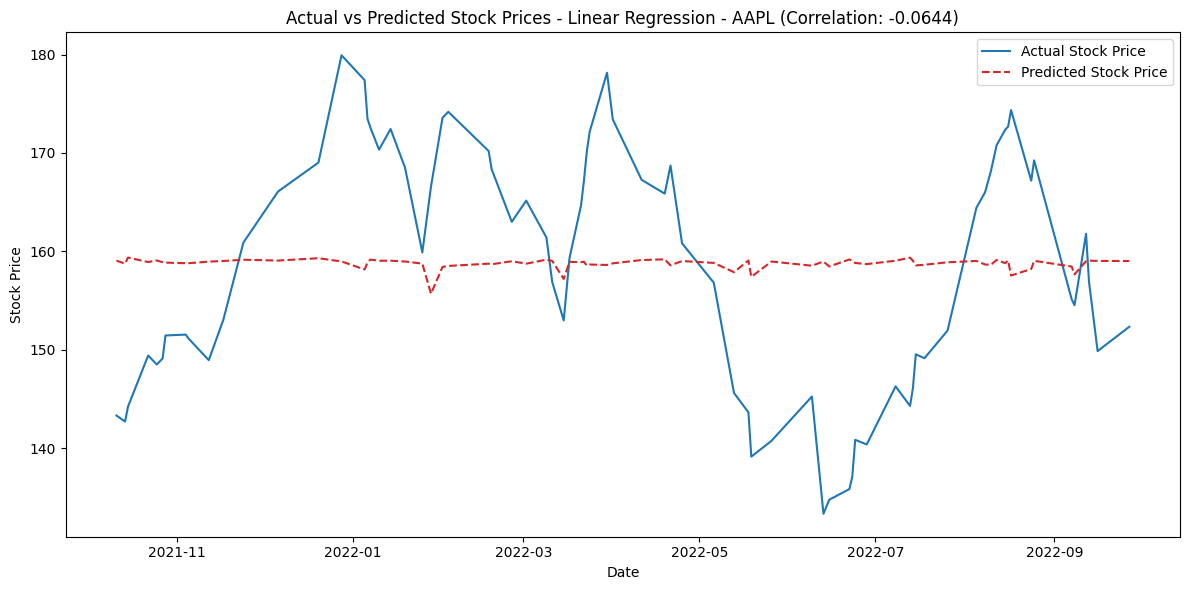

In [113]:
aapl_shifted = aapl_shifted.sort_values(by="Date")



X = aapl_shifted[['Subjectivity', 'Polarity']]  
y = aapl_shifted['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Linear Regression model instance
clf_lr = LinearRegression()

# Fit the model to the training data
clf_lr.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_lr.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)



plot_df = pd.DataFrame({
    'Date': aapl_shifted.loc[y_test.index, 'Date'],
    'Actual': y_test,
    'Predicted': y_pred
})

# Sort the DataFrame by date
plot_df = plot_df.sort_values(by="Date")

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting actual and predicted stock prices against Date
ax.plot(plot_df['Date'], plot_df['Actual'], color='tab:blue', label='Actual Stock Price')
ax.plot(plot_df['Date'], plot_df['Predicted'], color='tab:red', linestyle='--', label='Predicted Stock Price')
correlation = plot_df['Actual'].corr(plot_df['Predicted'])
print(f"Correlation between Actual and Predicted Stock Prices: {correlation:.2f}")

# Setting labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.set_title(f'Actual vs Predicted Stock Prices - Linear Regression - AAPL (Correlation: {correlation:.4f})')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()





In [40]:
###########################################
##########################################################
###############################################################

# TSM 

X = tsm_shifted[['Subjectivity', 'Polarity']]
y = tsm_shifted['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Define the hyperparameters and their distributions
param_dist = {
    'n_estimators': np.arange(10, 200, 10),
    'max_features': [ 'sqrt', 'log2'],
    'max_depth': np.arange(1, 20, 1),
    'min_samples_split': np.arange(2, 20, 1),
    'min_samples_leaf': np.arange(1, 20, 1),
    'bootstrap': [True, False]
}

# Initialize the regressor
rf = RandomForestRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

# Print the best parameters
print(random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 18, 'max_features': 'sqrt', 'max_depth': 1, 'bootstrap': False}


In [107]:


#machine learning - TSM - rf regression
X = tsm_shifted[['Subjectivity', 'Polarity']]
y = tsm_shifted['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest regressor instance
clf_rf = RandomForestRegressor(n_estimators = 70,
min_samples_split = 5,
min_samples_leaf = 18,
max_features = 'sqrt',
max_depth = 1,
bootstrap = False
)

# Fit the model to the training data
clf_rf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_rf.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 14.420005229980868
Mean Squared Error: 265.70688783795816
R-squared: -0.013409595854582568


Correlation between Actual and Predicted Stock Prices: 0.12


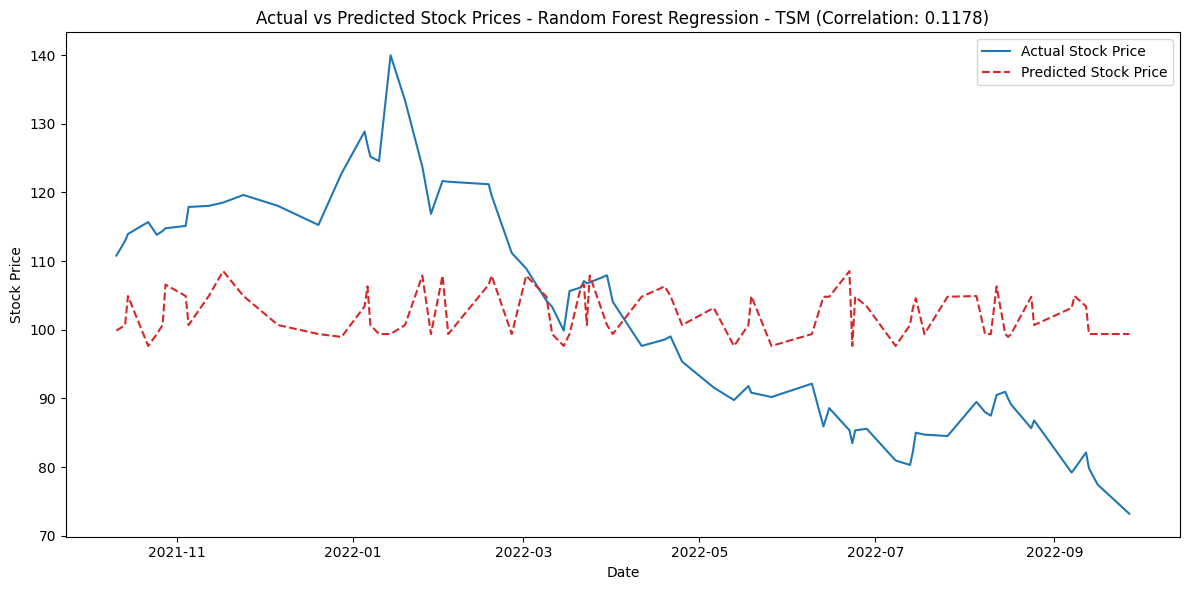

Correlation between Actual and Predicted Stock Prices: 0.12


In [110]:
tsm_shifted = tsm_shifted.sort_values(by="Date")


X = tsm_shifted[['Subjectivity', 'Polarity']]
y = tsm_shifted['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest regressor instance
clf_rf = RandomForestRegressor(n_estimators = 40,
min_samples_split = 17,
min_samples_leaf = 16,
max_features = 'log2',
max_depth = 2,
bootstrap = False
)

# Fit the model to the training data
clf_rf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_rf.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plot_df = pd.DataFrame({
    'Date': tsm_shifted.loc[y_test.index, 'Date'],
    'Actual': y_test,
    'Predicted': y_pred
})

# Sort the DataFrame by date
plot_df = plot_df.sort_values(by="Date")

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting actual and predicted stock prices against Date
ax.plot(plot_df['Date'], plot_df['Actual'], color='tab:blue', label='Actual Stock Price')
ax.plot(plot_df['Date'], plot_df['Predicted'], color='tab:red', linestyle='--', label='Predicted Stock Price')

correlation = plot_df['Actual'].corr(plot_df['Predicted'])
print(f"Correlation between Actual and Predicted Stock Prices: {correlation:.2f}")

# Setting labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.set_title(f'Actual vs Predicted Stock Prices - Random Forest Regression - TSM (Correlation: {correlation:.4f})')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

correlation = plot_df['Actual'].corr(plot_df['Predicted'])
print(f"Correlation between Actual and Predicted Stock Prices: {correlation:.2f}")



In [114]:


# - regression - TSM

X = tsm_shifted[['Subjectivity', 'Polarity']]  
y = tsm_shifted['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Linear Regression model instance
clf_lr = LinearRegression()

# Fit the model to the training data
clf_lr.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_lr.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 14.472893107577425
Mean Squared Error: 270.7816349391362
R-squared: -0.03276474863483503


Mean Absolute Error: 14.472893107577425
Mean Squared Error: 270.7816349391362
R-squared: -0.03276474863483503
Correlation between Actual and Predicted Stock Prices: -0.01


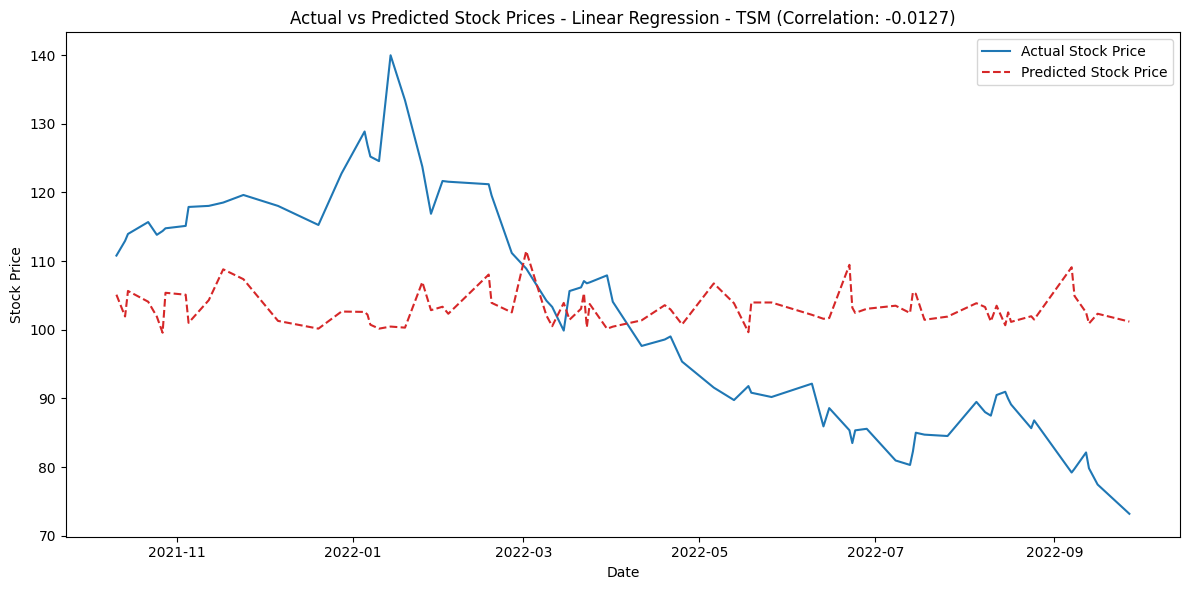

In [112]:
tsm_shifted = tsm_shifted.sort_values(by="Date")


X = tsm_shifted[['Subjectivity', 'Polarity']]  
y = tsm_shifted['Avg. Stock price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Linear Regression model instance
clf_lr = LinearRegression()

# Fit the model to the training data
clf_lr.fit(X_train, y_train)

# Predict on the test data
y_pred = clf_lr.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")





plot_df = pd.DataFrame({
    'Date': tsm_shifted.loc[y_test.index, 'Date'],
    'Actual': y_test,
    'Predicted': y_pred
})

# Sort the DataFrame by date
plot_df = plot_df.sort_values(by="Date")

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting actual and predicted stock prices against Date
ax.plot(plot_df['Date'], plot_df['Actual'], color='tab:blue', label='Actual Stock Price')
ax.plot(plot_df['Date'], plot_df['Predicted'], color='tab:red', linestyle='--', label='Predicted Stock Price')

correlation = plot_df['Actual'].corr(plot_df['Predicted'])
print(f"Correlation between Actual and Predicted Stock Prices: {correlation:.2f}")


# Setting labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.set_title(f'Actual vs Predicted Stock Prices - Linear Regression - TSM (Correlation: {correlation:.4f})')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

